# LinkNet Road Segmentation
**SAM paper:** https://arxiv.org/pdf/2304.02643.pdf​
<p>

**Link to the dataset used in this demonstration:**  https://www.kaggle.com/insaff/massachusetts-roads-dataset
    



In [38]:
import json,os,math,copy,sys,random
import glob
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2
import numpy as np
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize
import os
import cv2
from tqdm import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.measure import label, regionprops
from skimage.util import montage
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from transformers import SamProcessor
# Load the model
from transformers import SamModel
from skimage.morphology import label as sklabel
from datasets import Dataset
from PIL import Image
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.is_available()

True

In [9]:
base_path = '/mnt/d/data/road_segmentation_ideal'

<h1>Data Preprocessing</h2>
    <h4><li>crop data into smaller tiles 256*256 px</li>
    <li>clean data where no road mask present </li> </h4>

In [5]:
def dir_create(path):
    if (os.path.exists(path)) and (os.listdir(path) != []):
        os.system("rm -rf "+path)
        os.makedirs(path)
    if not os.path.exists(path):
        os.makedirs(path)
        
def crop(input_file, height, width):
    img = Image.open(input_file)
    img_width, img_height = img.size
    width_right=width
    height_bottom=height
    for i in range(math.ceil(img_height/height)):
        for j in range(math.ceil(img_width/width)):
            
            if (j+1)*width > img_width:
                width_right = img_width
            if (i+1)*height > img_height:
                height_bottom = img_height
            if (j+1)*width <= img_width and (i+1)*height <= img_height:
                height_bottom = (i+1)*height
                width_right = (j+1)*width
                
            box = (j*width, i*height, width_right, height_bottom)  
            #print(box,i,j,math.ceil(img_width//width),img_width, img_height)
            yield img.crop(box)
            

def split(inp_img_dir, inp_msk_dir, out_dir, height, width, 
          start_num):
    image_dir = os.path.join(out_dir, 'images')
    mask_dir = os.path.join(out_dir, 'masks')
    dir_create(out_dir)
    dir_create(image_dir)
    dir_create(mask_dir)
    img_list = [f for f in
                os.listdir(inp_img_dir)
                if os.path.isfile(os.path.join(inp_img_dir, f))]
    file_num = 0
    for infile in img_list:
        infile_path = os.path.join(inp_img_dir, infile)
        mask_path = os.path.join(inp_msk_dir,
                                   infile.split('.')[0] + '.png')
        
        if not os.path.exists(infile_path) or not os.path.exists(mask_path):
            print('file not exists:',infile.split('.')[0] + '.png')
            continue
        
        for k, piece in enumerate(crop(infile_path,
                                       height, width), start_num):
            img = Image.new('RGB', (height, width), 0)
            img.paste(piece)
            img_path = os.path.join(image_dir, 
                                    infile.split('.')[0]+ '_'
                                    + str(k).zfill(5) + '.png')
            img.save(img_path)
        infile_path = os.path.join(inp_msk_dir,
                                   infile.split('.')[0] + '.png')
        for k, piece in enumerate(crop(infile_path,
                                       height, width), start_num):
            msk = Image.new('RGB', (height, width), 0)
            msk.paste(piece)
            msk_path = os.path.join(mask_dir,
                                    infile.split('.')[0] + '_'
                                    + str(k).zfill(5) + '.png')
            msk.save(msk_path)
        file_num += 1
        sys.stdout.write("\rFile %s was processed." % file_num)
        sys.stdout.flush()

In [ ]:
height = 256
width = 256

train = 'training/input'
mask = 'training/output'
clean_train = 'op_train'
inp_img_dir = os.path.join(base_path,train)
inp_msk_dir = os.path.join(base_path,mask)
out_dir = os.path.join(base_path,clean_train)
start_num = 1
split(inp_img_dir, inp_msk_dir, out_dir, height, width, 
          start_num)

test = 'testing/input'
mask = 'testing/output'
clean_test = 'op_test'
inp_img_dir = os.path.join(base_path,test)
inp_msk_dir = os.path.join(base_path,mask)
out_dir = os.path.join(base_path,clean_test)
start_num = 1
split(inp_img_dir, inp_msk_dir, out_dir, height, width, 
          start_num)

<h2><li>clean images where no mask present</li> </h2>

In [19]:
blank=[]
for i in ['train','test']:
    
    for f in glob.glob(os.path.join(base_path,'op_{}'.format(i),'masks','*.png')):
        img = cv2.imread(f,0)
        blank_pixel = np.sum(img)
        if(blank_pixel <1):
            blank.append(f)
            blank_file= os.path.basename(f)
            mask_path = os.path.join(base_path,'op_{}'.format(i),'masks',blank_file)
            img_path = os.path.join(base_path,'op_{}'.format(i),'images',blank_file)
            #print(,)
            if  os.path.exists(mask_path) and  os.path.exists(img_path):
                os.remove(mask_path)
                os.remove(img_path)
        
len(blank)

5804


<h2><li>Data-set dict preparation</li> </h2>    

In [10]:
from datasets import Dataset ,Image as hImage
from PIL import Image,ImageOps
image = []
label = []
for i in ['train']:
    for f in glob.glob(os.path.join(base_path,'op_{}'.format(i),'masks','*.png')):
        _file= os.path.basename(f)
        label.append(os.path.join(base_path,'op_{}'.format(i),'masks',_file))
        image.append(os.path.join(base_path,'op_{}'.format(i),'images',_file))

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = { "image": image, "label": label}
dataset = Dataset.from_dict(dataset_dict)#.cast_column("image", hImage()).cast_column("label", hImage())

In [32]:
img_num

8038

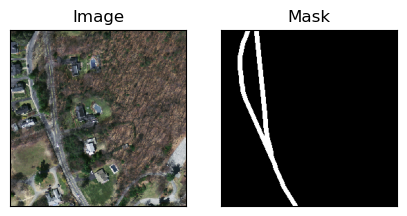

In [31]:
img_num = random.randint(0,len(image)-1)
example_image = Image.open(dataset[img_num]["image"])
example_mask =  (cv2.imread(dataset[img_num]['label'],cv2.IMREAD_GRAYSCALE) / 255.).astype(np.uint8)
fig, axes = plt.subplots(1, 2, figsize=(5, 5))
axes[0].imshow(np.array(example_image), cmap='gray')  
axes[0].set_title("Image")
axes[1].imshow(example_mask, cmap='gray')  
axes[1].set_title("Mask")
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
plt.show()

In [11]:
def _getArea(box):
    return (box[2] - box[0]) * (box[3] - box[1])
def get_bounding_box(mask_0):
  # get bounding box from mask
    thresh = threshold_otsu(mask_0)
    bw = closing(mask_0 > thresh, square(3))
    cleared = clear_border(bw)
    lbl_0 = sklabel(mask_0) 
    props = regionprops(lbl_0)
    area = []
    for prop in props:
        #print('Found bbox', prop.bbox,_getArea(prop.bbox))
        area.append(_getArea(prop.bbox))
    idx = np.argmax(area)
    return [props[idx].bbox[1],props[idx].bbox[0],props[idx].bbox[3],props[idx].bbox[2]]

In [7]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = np.array(Image.open(item["image"]))
    ground_truth_mask =  (cv2.imread(item['label'],cv2.IMREAD_GRAYSCALE) / 255.).astype(np.uint8)

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

#Get bounding boxes from mask.


In [8]:
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

2023-09-18 07:06:32.717939: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [10]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, drop_last=False)
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)
batch["ground_truth_mask"].shape

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])
ground_truth_mask torch.Size([1, 256, 256])


torch.Size([1, 256, 256])

# Load the model

In [11]:
model = SamModel.from_pretrained("facebook/sam-vit-base")
# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [ ]:
from torch.optim import Adam
import monai
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

# Training 

In [13]:

num_epochs = 1

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')
torch.save(model.state_dict(), "/mnt/d/data/road_segmentation_ideal/sam_model_checkpoint_2.pth")

100%|███████████████████████████████████████████████████████████████████████████| 23192/23192 [2:21:52<00:00,  2.72it/s]

EPOCH: 0
Mean loss: 0.2974005364814517


In [3]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

In [4]:
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
sat_model = SamModel(config=model_config)
sat_model.load_state_dict(torch.load("/mnt/d/data/road_segmentation_ideal/sam_model_checkpoint_2.pth"))

<All keys matched successfully>

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
sat_model.to(device)
base_model.to(device)

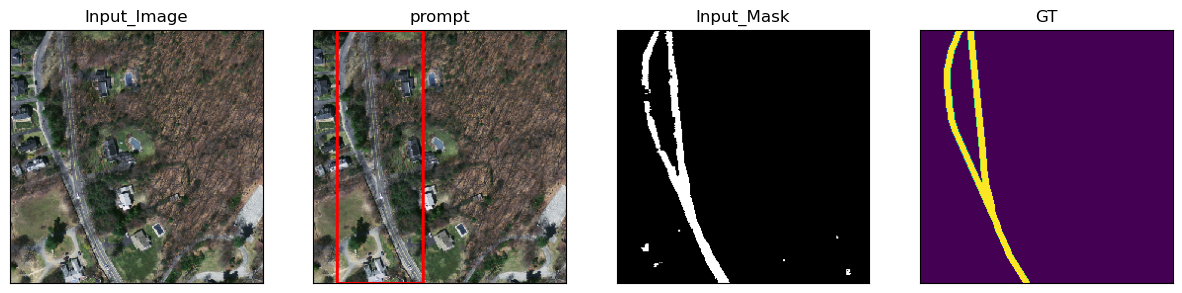

In [35]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

# let's take a random training example
idx = 8038#random.randint(0, 20000)

# load image
test_image = np.array(Image.open(dataset[idx]["image"]))

# get box prompt based on ground truth segmentation map
ground_truth_mask = (np.array(ImageOps.grayscale(Image.open(dataset[idx]["label"]))) / 255.).astype(np.uint8)
bbox_=prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

sat_model.eval()

# forward pass
with torch.no_grad():
    outputs = sat_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Input_Image")
axes[2].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[2].set_title("Input_Mask")
img_1 = copy.deepcopy(test_image)
cv2.rectangle(img_1, (bbox_[0], bbox_[1]), (bbox_[2], bbox_[3]), (255, 0, 0), 2)
# Plot the second image on the right
axes[1].imshow(img_1, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("prompt")

# Plot the second image on the right
axes[3].imshow(ground_truth_mask)  # Assuming the second image is grayscale
axes[3].set_title("GT")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()
